In [34]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, concat_ws, lpad, when, avg, count, expr, trim, udf, round as sql_round
from pyspark.sql.types import StringType

spark = (SparkSession.builder
         .appName("HRRP State-Level Penalty Analysis")
         .config("spark.driver.memory", "6g")
         .getOrCreate())

# hrrp_cleaned.csv was constructed from merging the results of the MapReduce pipeline output files
hrrp_pos = spark.read.option("header", "true").csv("hrrp_cleaned.csv")

hrrp_pos = hrrp_pos.withColumn(
    "FIPS",
    concat_ws("", lpad(col("FIPS_STATE_CD"), 2, "0"), lpad(col("FIPS_CNTY_CD"), 3, "0"))
)

svi = spark.read.option("header", "true").csv("SVI_2022_US_county.csv")
svi = svi.drop("State") if "State" in svi.columns else svi

full = (hrrp_pos.withColumn("FIPS", trim(col("FIPS")))
                 .join(svi.withColumn("FIPS", trim(col("FIPS"))), on="FIPS", how="left"))

def safe_cast_numeric(colname):
    return when(col(colname).rlike("^[0-9]+(\\.[0-9]+)?$"), col(colname).cast("double"))

full = (full
    .withColumn("ERR", safe_cast_numeric("Excess Readmission Ratio"))
    .withColumn("Readmits", safe_cast_numeric("Number of Readmissions"))
    .withColumn("RPL_THEME1", safe_cast_numeric("RPL_THEME1"))
    .withColumn("RPL_THEMES", safe_cast_numeric("RPL_THEMES"))
    .withColumn("Penalized", when(col("ERR") > 1.0, 1).otherwise(0))
)

fips_map = {
    '01':'AL','02':'AK','04':'AZ','05':'AR','06':'CA','08':'CO','09':'CT','10':'DE','11':'DC','12':'FL','13':'GA','15':'HI',
    '16':'ID','17':'IL','18':'IN','19':'IA','20':'KS','21':'KY','22':'LA','23':'ME','24':'MD','25':'MA','26':'MI','27':'MN',
    '28':'MS','29':'MO','30':'MT','31':'NE','32':'NV','33':'NH','34':'NJ','35':'NM','36':'NY','37':'NC','38':'ND','39':'OH',
    '40':'OK','41':'OR','42':'PA','44':'RI','45':'SC','46':'SD','47':'TN','48':'TX','49':'UT','50':'VT','51':'VA','53':'WA',
    '54':'WV','55':'WI','56':'WY'
}
def fips_to_state(fips2):
    return fips_map.get((fips2 or "").zfill(2), None)
fips_udf = udf(fips_to_state, StringType())
full = full.withColumn("State", fips_udf(col("FIPS_STATE_CD")))

df = hrrp_pos

state_summary = full.groupBy("State").agg(
    count("Facility ID").alias("Hospitals"),
    expr("sum(Penalized)").alias("Penalized_Count"),
    avg("ERR").alias("Avg_ERR"),
    avg("Readmits").alias("Avg_Readmissions"),
    avg("RPL_THEME1").alias("Avg_RPL_THEME1"),
    avg("RPL_THEMES").alias("Avg_RPL_THEMES")
).withColumn("Percent_Penalized", (col("Penalized_Count") / col("Hospitals")) * 100)

by_state = state_summary.select(
    "State", "Hospitals", sql_round(col("Percent_Penalized"), 2).alias("Percent_Penalized")
)

top5_states = by_state.orderBy(col("Percent_Penalized").desc(), col("Hospitals").desc())
top5_states.show(5, truncate=False)

bottom5_states = by_state.orderBy(col("Percent_Penalized").asc(), col("Hospitals").desc())
bottom5_states.show(5, truncate=False)

+-----+---------+-----------------+
|State|Hospitals|Percent_Penalized|
+-----+---------+-----------------+
|MA   |330      |49.39            |
|NJ   |366      |48.91            |
|FL   |1002     |46.61            |
|DC   |36       |44.44            |
|IL   |696      |41.67            |
+-----+---------+-----------------+
only showing top 5 rows

+-----+---------+-----------------+
|State|Hospitals|Percent_Penalized|
+-----+---------+-----------------+
|ID   |96       |7.29             |
|SD   |108      |8.33             |
|WY   |66       |10.61            |
|UT   |192      |13.54            |
|MT   |66       |15.15            |
+-----+---------+-----------------+
only showing top 5 rows



In [35]:
from pyspark.sql.functions import corr

correlation_metrics = [
    ("Avg_ERR", "Percent_Penalized"),
    ("Avg_Readmissions", "Percent_Penalized"),
    ("Avg_RPL_THEME1", "Percent_Penalized"),
    ("Avg_RPL_THEMES", "Percent_Penalized")
]

for col1, col2 in correlation_metrics:
    value = state_summary.select(corr(col1, col2)).first()[0]
    print(f"Correlation between {col1} and {col2}: {value:.4f}")

Correlation between Avg_ERR and Percent_Penalized: 0.9102
Correlation between Avg_Readmissions and Percent_Penalized: 0.6129
Correlation between Avg_RPL_THEME1 and Percent_Penalized: 0.2742
Correlation between Avg_RPL_THEMES and Percent_Penalized: 0.2726


In [36]:
from pyspark.sql.functions import col, when, regexp_replace

df = hrrp_pos

# POS numeric columns of interest (clean only if present)
numeric_columns = [
    "CRTFD_BED_CNT", "MDCD_NF_BED_CNT", "MDCR_SNF_BED_CNT", "MDCR_MDCD_SNF_BED_CNT",
    "HOSPC_BED_CNT", "AIDS_BED_CNT", "REHAB_BED_CNT", "VNTLTR_BED_CNT",
    "BED_CNT", "ICU_SRVC_CD", "RN_FLTM_CNT", "RN_PRTM_CNT", "LPN_CNT", "EMPLEE_CNT"
]

df = df.withColumn(
    "ERR", when(col("Excess Readmission Ratio").rlike("^[0-9.]+$"),
                col("Excess Readmission Ratio").cast("double"))
)

present_numeric = [c for c in numeric_columns if c in df.columns]
for c in present_numeric:
    df = df.withColumn(c, regexp_replace(col(c).cast("string"), ",", ""))
    df = df.withColumn(c, when(col(c).rlike("^[0-9]+(\\.[0-9]+)?$"), col(c).cast("double")))

columns_to_check = ["ERR"] + present_numeric
df_clean = df.select(columns_to_check).na.drop(how="any")

df_clean.printSchema()
df_clean.show(5, truncate=False)

print("Pearson correlation with Excess Readmission Ratio (ERR):\n")

# Correlations (gracefully skip missing columns)
for c in numeric_columns:
    if c not in df.columns:
        print(f"{c}: N/A (column not present)")
        continue
    filtered = df.select("ERR", c).dropna(how="any")
    n = filtered.count()
    if n > 0:
        print(f"{c}: {filtered.stat.corr('ERR', c):.4f} ({n} records)")
    else:
        print(f"{c}: N/A (no valid records)")


root
 |-- ERR: double (nullable = true)
 |-- CRTFD_BED_CNT: double (nullable = true)
 |-- BED_CNT: double (nullable = true)
 |-- ICU_SRVC_CD: double (nullable = true)

+------+-------------+-------+-----------+
|ERR   |CRTFD_BED_CNT|BED_CNT|ICU_SRVC_CD|
+------+-------------+-------+-----------+
|0.9483|420.0        |420.0  |1.0        |
|0.9509|420.0        |420.0  |1.0        |
|0.933 |420.0        |420.0  |1.0        |
|1.0597|420.0        |420.0  |1.0        |
|0.9654|420.0        |420.0  |1.0        |
+------+-------------+-------+-----------+
only showing top 5 rows

Pearson correlation with Excess Readmission Ratio (ERR):

CRTFD_BED_CNT: 0.0245 (11927 records)
MDCD_NF_BED_CNT: N/A (column not present)
MDCR_SNF_BED_CNT: N/A (column not present)
MDCR_MDCD_SNF_BED_CNT: N/A (column not present)
HOSPC_BED_CNT: N/A (column not present)
AIDS_BED_CNT: N/A (column not present)
REHAB_BED_CNT: N/A (column not present)
VNTLTR_BED_CNT: N/A (column not present)
BED_CNT: 0.0268 (11927 records)

In [37]:
summary_by_penalty = full.groupBy("Penalized").agg(
    {"CRTFD_BED_CNT": "avg", "BED_CNT": "avg", "ICU_SRVC_CD": "avg",
     "RPL_THEME1": "avg", "RPL_THEMES": "avg",
     "ERR": "avg", "Readmits": "avg"}
)

summary_by_penalty.show(truncate=False)


+---------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|Penalized|avg(RPL_THEMES)   |avg(Readmits)    |avg(CRTFD_BED_CNT)|avg(BED_CNT)      |avg(ERR)          |avg(RPL_THEME1)   |avg(ICU_SRVC_CD)  |
+---------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|1        |0.6132935259310807|50.62730130220027|313.56673546611626|322.2483660130719 |1.061542277261783 |0.5669715628263178|1.1881664946680426|
|0        |0.5949172759059199|44.97463866921189|214.26362633900442|220.55781348456208|0.9448227711434658|0.5538063095994966|1.0385948330182735|
+---------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+



In [38]:
from pyspark.sql.functions import when

# Sort bed count into buckets
binned = full.withColumn("Bed_Size_Category", when(col("BED_CNT") < 50, "<50")
                         .when(col("BED_CNT") < 100, "50–99")
                         .when(col("BED_CNT") < 200, "100–199")
                         .when(col("BED_CNT") < 300, "200–299")
                         .otherwise("300+"))

# Compute penalty rate per category
bed_penalty_rate = binned.groupBy("Bed_Size_Category").agg(
    expr("count(*) as Total_Facilities"),
    expr("sum(Penalized) as Penalized_Count"),
    expr("avg(ERR) as Avg_ERR"),
    expr("avg(RPL_THEMES) as Avg_RPL_THEMES"),
    expr("avg(RPL_THEME1) as Avg_RPL_THEME1"),
    expr("avg(Penalized) * 100 as Percent_Penalized")
).orderBy("Bed_Size_Category")

bed_penalty_rate.show(truncate=False)


+-----------------+----------------+---------------+------------------+------------------+------------------+------------------+
|Bed_Size_Category|Total_Facilities|Penalized_Count|Avg_ERR           |Avg_RPL_THEMES    |Avg_RPL_THEME1    |Percent_Penalized |
+-----------------+----------------+---------------+------------------+------------------+------------------+------------------+
|100–199          |4494            |1409           |1.0036746099290799|0.5590823211875814|0.5210295546558708|31.35291499777481 |
|200–299          |2898            |1169           |1.0076711372904394|0.602484067085949 |0.5540966457023005|40.33816425120773 |
|300+             |5598            |2422           |1.0033862692703008|0.6472979392624741|0.5872854663774427|43.26545194712397 |
|50–99            |3030            |594            |0.9921452529452535|0.5456350597609613|0.5276274900398374|19.603960396039604|
|<50              |2490            |220            |0.9798581081081081|0.6360489104116254|0.59988

In [39]:
icu_summary = full.groupBy("ICU_SRVC_CD").agg(
    expr("count(*) as Total"),
    expr("sum(Penalized) as Penalized_Count"),
    expr("avg(ERR) as Avg_ERR"),
    expr("avg(Penalized) * 100 as Percent_Penalized")
).orderBy("ICU_SRVC_CD")

icu_summary.show()


+-----------+-----+---------------+------------------+------------------+
|ICU_SRVC_CD|Total|Penalized_Count|           Avg_ERR| Percent_Penalized|
+-----------+-----+---------------+------------------+------------------+
|          0| 2502|            283|0.9866413580246921|11.310951239008793|
|          1|13860|           4818|1.0023406281764586| 34.76190476190476|
|          2|  210|             49|1.0083185567010309|23.333333333333332|
|          3| 1938|            664|1.0039663690476213| 34.26212590299277|
+-----------+-----+---------------+------------------+------------------+



In [40]:
from pyspark.sql.functions import corr

for colname in ["CRTFD_BED_CNT", "BED_CNT", "ICU_SRVC_CD", "RPL_THEME1", "RPL_THEMES"]:
    full.select("ERR", colname).dropna().agg(corr("ERR", colname).alias(colname)).show()


+--------------------+
|       CRTFD_BED_CNT|
+--------------------+
|0.024538954260312513|
+--------------------+

+--------------------+
|             BED_CNT|
+--------------------+
|0.026797337107035718|
+--------------------+

+--------------------+
|         ICU_SRVC_CD|
+--------------------+
|0.024688442362392968|
+--------------------+

+-------------------+
|         RPL_THEME1|
+-------------------+
|0.09769789987388694|
+-------------------+

+-------------------+
|         RPL_THEMES|
+-------------------+
|0.09405626389933283|
+-------------------+



In [41]:
from pyspark.sql.functions import avg, stddev, count, col, expr, round

err_stats = full.groupBy("Penalized").agg(
    count("*").alias("n"),
    round(avg("ERR"), 4).alias("avg_ERR"),
    round(stddev("ERR"), 4).alias("stddev_ERR")
)

print("Mean and Stddev of ERR by Penalized Group")
err_stats.show()

full = full.withColumn("ICU", col("ICU_SRVC_CD").cast("int"))

# | ICU_SRVC_CD | Description                                       |
# | ----------- | ------------------------------------------------  |
# | 0           | No ICU service provided                           |
# | 1           | General Medical/Surgical ICU                      |
# | 2           | Cardiac ICU (CCU) only                            |
# | 3           | Both General ICU and Cardiac ICU services offered |

icu_penalty = full.groupBy("ICU", "Penalized").count().orderBy("ICU", "Penalized")

print("ICU vs Penalized Counts")
icu_penalty.show()

icu_totals = full.groupBy("ICU").agg(
    count("*").alias("total"),
    expr("sum(Penalized)").alias("penalized_count"),
    round(expr("sum(Penalized) / count(*)"), 4).alias("penalty_rate")
)

print("=== ICU-wise Penalty Rate ===")
icu_totals.show()

# This suggests that the presence of ICU services - especially general medical/surgical ICUs - is strongly associated with higher penalty rates under the HRRP program.

Mean and Stddev of ERR by Penalized Group
+---------+-----+-------+----------+
|Penalized|    n|avg_ERR|stddev_ERR|
+---------+-----+-------+----------+
|        1| 5814| 1.0615|    0.0604|
|        0|12696| 0.9448|    0.0505|
+---------+-----+-------+----------+

ICU vs Penalized Counts
+---+---------+-----+
|ICU|Penalized|count|
+---+---------+-----+
|  0|        0| 2219|
|  0|        1|  283|
|  1|        0| 9042|
|  1|        1| 4818|
|  2|        0|  161|
|  2|        1|   49|
|  3|        0| 1274|
|  3|        1|  664|
+---+---------+-----+

=== ICU-wise Penalty Rate ===
+---+-----+---------------+------------+
|ICU|total|penalized_count|penalty_rate|
+---+-----+---------------+------------+
|  1|13860|           4818|      0.3476|
|  3| 1938|            664|      0.3426|
|  2|  210|             49|      0.2333|
|  0| 2502|            283|      0.1131|
+---+-----+---------------+------------+



In [42]:
from pyspark.sql.functions import count, sum, col, when

# Bed size category
full = full.withColumn("Bed_Size_Category", when(col("CRTFD_BED_CNT") <= 50, "Small")
                                          .when((col("CRTFD_BED_CNT") > 50) & (col("CRTFD_BED_CNT") <= 200), "Medium")
                                          .when(col("CRTFD_BED_CNT") > 200, "Large")
                                          .otherwise("Unknown"))

icu_bed_penalty = full.groupBy("ICU", "Bed_Size_Category") \
    .agg(
        count("*").alias("total"),
        sum("Penalized").alias("penalized_count")
    ) \
    .withColumn("penalty_rate", (col("penalized_count") / col("total")).cast("double")) \
    .orderBy("ICU", "Bed_Size_Category")

icu_bed_penalty.show(truncate=False)

# Large facilities have consistently higher penalty rates, regardless of ICU level.
# Facilities with no ICU but large bed size still have a 38.2% penalty rate — suggesting size is a strong predictor even without ICU.
# Small hospitals, even with ICUs, tend to have lower penalty rates.
# The ICU level alone is not a perfect predictor, but when combined with size, it becomes revealing.


+---+-----------------+-----+---------------+--------------------+
|ICU|Bed_Size_Category|total|penalized_count|penalty_rate        |
+---+-----------------+-----+---------------+--------------------+
|0  |Large            |246  |94             |0.3821138211382114  |
|0  |Medium           |624  |89             |0.14262820512820512 |
|0  |Small            |1632 |100            |0.061274509803921566|
|1  |Large            |6960 |2974           |0.4272988505747126  |
|1  |Medium           |5952 |1699           |0.2854502688172043  |
|1  |Small            |948  |145            |0.1529535864978903  |
|2  |Large            |60   |25             |0.4166666666666667  |
|2  |Medium           |102  |23             |0.22549019607843138 |
|2  |Small            |48   |1              |0.020833333333333332|
|3  |Large            |972  |395            |0.4063786008230453  |
|3  |Medium           |840  |252            |0.3                 |
|3  |Small            |126  |17             |0.134920634920634

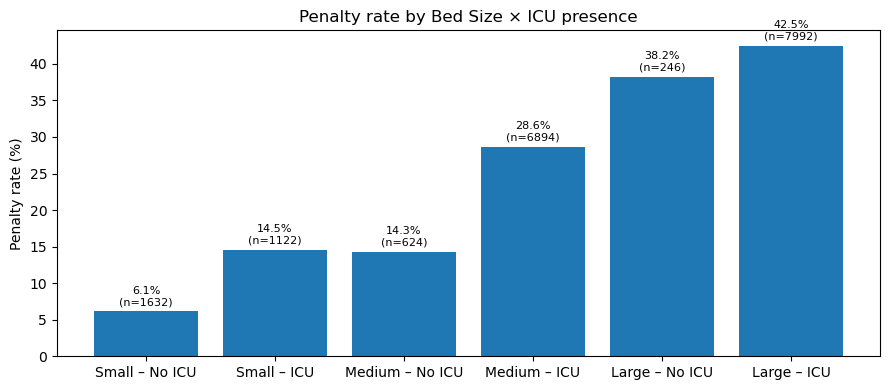

In [43]:
# --- Bar chart: penalty rate by Bed Size × ICU presence (6 bars) ---

from pyspark.sql.functions import col, when, count, sum as _sum, lit
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1) Define Bed size buckets and ICU presence (ICU>0 OR ICU_SRVC_CD>=1)
df = (
    full
    .withColumn("BEDS", col("CRTFD_BED_CNT").cast("double"))
    .withColumn("Bed_Size_Category",
        when(col("BEDS") <= 50, "Small")
        .when((col("BEDS") > 50) & (col("BEDS") <= 200), "Medium")
        .when(col("BEDS") > 200, "Large")
        .otherwise("Unknown")
    )
    .withColumn("ICU_PRESENT",
        when((col("ICU").cast("double") > 0) | (col("ICU_SRVC_CD").cast("double") >= 1), "ICU")
        .otherwise("No ICU")
    )
)

# 2) Aggregate from raw rows (correctly weighted)
agg = (
    df.groupBy("Bed_Size_Category", "ICU_PRESENT")
      .agg(
          count(lit(1)).alias("total"),
          _sum(col("Penalized").cast("int")).alias("penalized_count")
      )
      .withColumn("penalty_rate", col("penalized_count")/col("total"))
)

# 3) To pandas and create a single bar per (size, ICU) combo
pdf = agg.toPandas()

# Order categories
size_order = ["Small", "Medium", "Large"]  # drop "Unknown" for a cleaner chart; add if you want
icu_order  = ["No ICU", "ICU"]

pdf = pdf[pdf["Bed_Size_Category"].isin(size_order)]
pdf["Bed_Size_Category"] = pd.Categorical(pdf["Bed_Size_Category"], size_order)
pdf["ICU_PRESENT"] = pd.Categorical(pdf["ICU_PRESENT"], icu_order)
pdf = pdf.sort_values(["Bed_Size_Category","ICU_PRESENT"])

# Build labels like "Small – No ICU", "Small – ICU", ...
pdf["label"] = pdf["Bed_Size_Category"].astype(str) + " – " + pdf["ICU_PRESENT"].astype(str)

x = np.arange(len(pdf))
y = (pdf["penalty_rate"] * 100).to_numpy()
n = pdf["total"].to_numpy()

# 4) Plot: one simple bar per combo
plt.figure(figsize=(9, 4))
bars = plt.bar(x, y)

plt.xticks(x, pdf["label"].tolist(), rotation=0)
plt.ylabel("Penalty rate (%)")
plt.title("Penalty rate by Bed Size × ICU presence")

# Annotate with % and n
for b, v, nn in zip(bars, y, n):
    if pd.notnull(v):
        plt.text(b.get_x() + b.get_width()/2, v + 0.6, f"{v:.1f}%\n(n={int(nn)})",
                 ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()


In [44]:
icu_state_penalty = full.groupBy("ICU", "STATE") \
    .agg(
        count("*").alias("total"),
        sum(col("Penalized").cast("int")).alias("penalized_count")
    ) \
    .withColumn("penalty_rate", (col("penalized_count") / col("total")).cast("double")) \
    .orderBy("ICU", "STATE")

icu_state_penalty.show()

+---+-----+-----+---------------+--------------------+
|ICU|STATE|total|penalized_count|        penalty_rate|
+---+-----+-----+---------------+--------------------+
|  0|   AK|    6|              0|                 0.0|
|  0|   AL|  102|             10| 0.09803921568627451|
|  0|   AR|   42|              5| 0.11904761904761904|
|  0|   AZ|   84|             11| 0.13095238095238096|
|  0|   CA|  132|             19| 0.14393939393939395|
|  0|   CO|   54|              6|  0.1111111111111111|
|  0|   CT|   12|              0|                 0.0|
|  0|   FL|   48|             17|  0.3541666666666667|
|  0|   GA|   78|             11| 0.14102564102564102|
|  0|   IA|   12|              0|                 0.0|
|  0|   ID|   36|              1|0.027777777777777776|
|  0|   IL|   24|              6|                0.25|
|  0|   IN|   48|              3|              0.0625|
|  0|   KS|   84|              6| 0.07142857142857142|
|  0|   KY|   42|             15| 0.35714285714285715|
|  0|   LA

In [45]:
from pyspark.sql.functions import col, when, count, sum as _sum, regexp_replace
from pyspark.ml.feature import QuantileDiscretizer

cleaned = full.withColumn("RN_CNT_CLEAN", regexp_replace(col("RN_CNT"), ",", ""))

cleaned = cleaned.withColumn("RN_CNT_DOUBLE", col("RN_CNT_CLEAN").cast("double"))

rn_staffed = cleaned.filter(col("RN_CNT_DOUBLE").isNotNull())

discretizer = QuantileDiscretizer(
    numBuckets=4,
    inputCol="RN_CNT_DOUBLE",
    outputCol="RN_Category",
    handleInvalid="skip"
)
rn_bucketed = discretizer.fit(rn_staffed).transform(rn_staffed)

#Label the quartile bins
rn_bucketed = rn_bucketed.withColumn(
    "RN_Category_Label",
    when(col("RN_Category") == 0, "Low")
    .when(col("RN_Category") == 1, "Medium-Low")
    .when(col("RN_Category") == 2, "Medium-High")
    .when(col("RN_Category") == 3, "High")
)

rn_penalty = rn_bucketed.groupBy("RN_Category_Label").agg(
    count("*").alias("total"),
    _sum(col("Penalized").cast("int")).alias("penalized_count")
).withColumn(
    "penalty_rate", col("penalized_count") / col("total")
).orderBy("RN_Category_Label")

rn_penalty.show(truncate=False)

# Surprisingly, facilities with higher registered nurse staffing levels tend to have higher readmission penalty rates. This suggests that the penalty system may disproportionately impact larger or more complex hospitals, rather than reflecting poor care. These findings support the idea that HRRP penalties do not fully adjust for patient or operational complexity.

+-----------------+-----+---------------+-------------------+
|RN_Category_Label|total|penalized_count|penalty_rate       |
+-----------------+-----+---------------+-------------------+
|High             |4644 |2004           |0.4315245478036176 |
|Low              |4620 |737            |0.1595238095238095 |
|Medium-High      |4632 |1771           |0.38234024179620035|
|Medium-Low       |4614 |1302           |0.28218465539661897|
+-----------------+-----+---------------+-------------------+



In [46]:
svi.columns

['ST',
 'STATE',
 'ST_ABBR',
 'STCNTY',
 'COUNTY',
 'FIPS',
 'LOCATION',
 'AREA_SQMI',
 'E_TOTPOP',
 'M_TOTPOP',
 'E_HU',
 'M_HU',
 'E_HH',
 'M_HH',
 'E_POV150',
 'M_POV150',
 'E_UNEMP',
 'M_UNEMP',
 'E_HBURD',
 'M_HBURD',
 'E_NOHSDP',
 'M_NOHSDP',
 'E_UNINSUR',
 'M_UNINSUR',
 'E_AGE65',
 'M_AGE65',
 'E_AGE17',
 'M_AGE17',
 'E_DISABL',
 'M_DISABL',
 'E_SNGPNT',
 'M_SNGPNT',
 'E_LIMENG',
 'M_LIMENG',
 'E_MINRTY',
 'M_MINRTY',
 'E_MUNIT',
 'M_MUNIT',
 'E_MOBILE',
 'M_MOBILE',
 'E_CROWD',
 'M_CROWD',
 'E_NOVEH',
 'M_NOVEH',
 'E_GROUPQ',
 'M_GROUPQ',
 'EP_POV150',
 'MP_POV150',
 'EP_UNEMP',
 'MP_UNEMP',
 'EP_HBURD',
 'MP_HBURD',
 'EP_NOHSDP',
 'MP_NOHSDP',
 'EP_UNINSUR',
 'MP_UNINSUR',
 'EP_AGE65',
 'MP_AGE65',
 'EP_AGE17',
 'MP_AGE17',
 'EP_DISABL',
 'MP_DISABL',
 'EP_SNGPNT',
 'MP_SNGPNT',
 'EP_LIMENG',
 'MP_LIMENG',
 'EP_MINRTY',
 'MP_MINRTY',
 'EP_MUNIT',
 'MP_MUNIT',
 'EP_MOBILE',
 'MP_MOBILE',
 'EP_CROWD',
 'MP_CROWD',
 'EP_NOVEH',
 'MP_NOVEH',
 'EP_GROUPQ',
 'MP_GROUPQ',
 'EPL_POV15

In [47]:
from pyspark.sql.functions import col, when, count, sum as spark_sum, ntile, lit
from pyspark.sql.window import Window

svi_columns = [
    "EP_POV150", "EP_UNEMP", "EP_NOHSDP", "EP_UNINSUR",
    "EP_MINRTY", "EP_LIMENG", "EP_AGE65", "RPL_THEMES"
]

for svi_col in svi_columns:
    print(f"\n=== Penalty Rate by Quartile of {svi_col} ===")

    windowSpec = Window.orderBy(col(svi_col))
    windowSpec = Window.orderBy(col(svi_col)).partitionBy(lit(1))

    full_with_quartile = full.withColumn(
        f"{svi_col}_Quartile", ntile(4).over(windowSpec)
    )

    svi_penalty = full_with_quartile.groupBy(f"{svi_col}_Quartile") \
        .agg(
            count("*").alias("total"),
            spark_sum("Penalized").alias("penalized_count")
        ) \
        .withColumn("penalty_rate", (col("penalized_count") / col("total")).cast("double")) \
        .orderBy(f"{svi_col}_Quartile")

    svi_penalty.show(truncate=False)


# EP_UNEMP: nearly linear increase in penalty rates
# EP_LIMENG: clear linear rise in penalty rate across quartiles
# EP_MINRTY and EP_NOHSDP: nonlinear, potentially interacting effects


=== Penalty Rate by Quartile of EP_POV150 ===
+------------------+-----+---------------+-------------------+
|EP_POV150_Quartile|total|penalized_count|penalty_rate       |
+------------------+-----+---------------+-------------------+
|1                 |4628 |1476           |0.31892826274848746|
|2                 |4628 |1479           |0.31957649092480556|
|3                 |4627 |1540           |0.3328290468986384 |
|4                 |4627 |1319           |0.28506591744110654|
+------------------+-----+---------------+-------------------+


=== Penalty Rate by Quartile of EP_UNEMP ===
+-----------------+-----+---------------+-------------------+
|EP_UNEMP_Quartile|total|penalized_count|penalty_rate       |
+-----------------+-----+---------------+-------------------+
|1                |4628 |1163           |0.25129645635263614|
|2                |4628 |1504           |0.32497839239412274|
|3                |4627 |1576           |0.3406094661767884 |
|4                |4627 |1571 

In [48]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

columns_of_interest = [
    "EP_UNEMP", "EP_NOHSDP", "EP_LIMENG", "EP_MINRTY", "EP_UNINSUR",
    "EP_POV150", "EP_AGE65", "RN_CNT"
]

df_corr = full.select(["penalized"] + columns_of_interest)
for c in columns_of_interest:
    df_corr = df_corr.withColumn(c, col(c).cast("double"))

df_clean = df_corr.dropna(subset=columns_of_interest)

# Assemble vector and skip rows with invalid data
assembler = VectorAssembler(
    inputCols=columns_of_interest,
    outputCol="features",
    handleInvalid="skip"
)
vector_df = assembler.transform(df_clean).select("features")

corr_matrix = Correlation.corr(vector_df, "features", "pearson").head()[0].toArray()

for c in columns_of_interest:
    corr = df_clean.stat.corr("penalized", c)
    print(f"{c}: correlation with penalized = {corr}")


EP_UNEMP: correlation with penalized = 0.04351658653568677
EP_NOHSDP: correlation with penalized = -0.01697406781661238
EP_LIMENG: correlation with penalized = 0.05524109950267792
EP_MINRTY: correlation with penalized = 0.05485347123817996
EP_UNINSUR: correlation with penalized = -0.040815254865480266
EP_POV150: correlation with penalized = -0.024668438822422707
EP_AGE65: correlation with penalized = 0.00730101096638445
RN_CNT: correlation with penalized = 0.04299520676747402


In [49]:
from pyspark.sql.functions import col, when, regexp_replace
from pyspark.sql.types import DoubleType

full = full.withColumn("label", col("Penalized").cast("double"))

# The ICU levels are 0-3. > 0 means "ICU present" here
full = full.withColumn("ICU_PRESENT", when(col("ICU").cast("int") > 0, 1.0).otherwise(0.0))

candidates = [
    "RN_CNT", "CRTFD_BED_CNT", "BED_CNT", "ICU_PRESENT",     # POS/facility operations
    "EP_UNEMP", "EP_NOHSDP", "EP_LIMENG", "EP_MINRTY", "EP_UNINSUR", "EP_POV150", "EP_AGE65" # SVI at the county level
]

existing = set(full.columns)
usable = []
for c in candidates:
    if c in existing:
        full = full.withColumn(c, regexp_replace(col(c).cast("string"), ",", ""))
        full = full.withColumn(c, col(c).cast(DoubleType()))
        usable.append(c)

print("Features found & cast:", usable)

Features found & cast: ['RN_CNT', 'CRTFD_BED_CNT', 'BED_CNT', 'ICU_PRESENT', 'EP_UNEMP', 'EP_NOHSDP', 'EP_LIMENG', 'EP_MINRTY', 'EP_UNINSUR', 'EP_POV150', 'EP_AGE65']


In [50]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

assembler = VectorAssembler(
    inputCols=usable,
    outputCol="features",
    handleInvalid="skip"
)

dataset = assembler.transform(full).select("features", "label")
print("Dataset rows after assembly:", dataset.count())

train_df, test_df = dataset.randomSplit([0.7, 0.3], seed=42)
print("Train:", train_df.count(), "Test:", test_df.count())

lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=100, regParam=0.0, elasticNetParam=0.0)
lr_model = lr.fit(train_df)
lr_preds = lr_model.transform(test_df)

rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=200, maxDepth=8, seed=42)
rf_model = rf.fit(train_df)
rf_preds = rf_model.transform(test_df)

bin_eval = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
multi_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
multi_f1  = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

def show_metrics(name, preds):
    auc = bin_eval.evaluate(preds)
    acc = multi_acc.evaluate(preds)
    f1  = multi_f1.evaluate(preds)
    print(f"\n=== {name} ===")
    print(f"AUC: {auc:.4f} | Accuracy: {acc:.4f} | F1: {f1:.4f}")

    # Confusion matrix
    cm = (preds.groupBy("label", "prediction").count()
                .orderBy("label", "prediction"))
    cm.show(truncate=False)

show_metrics("Logistic Regression", lr_preds)
show_metrics("Random Forest", rf_preds)

# Logistic Regression Coefficients
for fname, coef in zip(usable, lr_model.coefficients):
    print(f"{fname:15s} : {coef:+.4f}")
print(f"Intercept         : {lr_model.intercept:+.4f}")

rf_importances = {}

for fname, imp in zip(usable, rf_model.featureImportances.toArray()):
    rf_importances[fname] = imp
    print(f"{fname:15s} : {imp:.4f}")


Dataset rows after assembly: 18330
Train: 12905 Test: 5425


25/08/13 23:19:56 WARN DAGScheduler: Broadcasting large task binary with size 1812.3 KiB


25/08/13 23:19:57 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


25/08/13 23:19:59 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


25/08/13 23:20:01 WARN DAGScheduler: Broadcasting large task binary with size 1407.1 KiB



=== Logistic Regression ===
AUC: 0.6452 | Accuracy: 0.6747 | F1: 0.5678
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|0.0  |0.0       |3584 |
|0.0  |1.0       |81   |
|1.0  |0.0       |1684 |
|1.0  |1.0       |76   |
+-----+----------+-----+

25/08/13 23:20:05 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


25/08/13 23:20:05 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


25/08/13 23:20:06 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB



=== Random Forest ===
AUC: 0.6830 | Accuracy: 0.6806 | F1: 0.5800
25/08/13 23:20:07 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


25/08/13 23:20:08 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|0.0  |0.0       |3584 |
|0.0  |1.0       |81   |
|1.0  |0.0       |1652 |
|1.0  |1.0       |108  |
+-----+----------+-----+

RN_CNT          : -0.0001
CRTFD_BED_CNT   : +0.0003
BED_CNT         : +0.0010
ICU_PRESENT     : +1.2108
EP_UNEMP        : +0.0589
EP_NOHSDP       : -0.0067
EP_LIMENG       : +0.0057
EP_MINRTY       : +0.0037
EP_UNINSUR      : -0.0102
EP_POV150       : -0.0089
EP_AGE65        : +0.0188
Intercept         : -2.6370
RN_CNT          : 0.1400
CRTFD_BED_CNT   : 0.2385
BED_CNT         : 0.2262
ICU_PRESENT     : 0.0515
EP_UNEMP        : 0.0610
EP_NOHSDP       : 0.0500
EP_LIMENG       : 0.0423
EP_MINRTY       : 0.0469
EP_UNINSUR      : 0.0482
EP_POV150       : 0.0456
EP_AGE65        : 0.0497


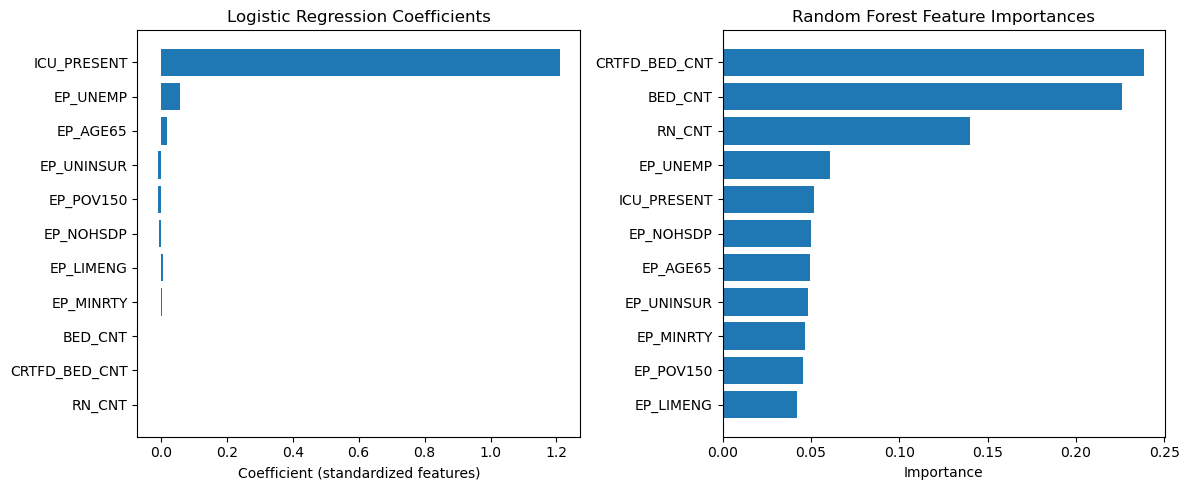

In [51]:
import matplotlib.pyplot as plt

#  Logistic Regression coefficients
lr_coefs = list(lr_model.coefficients)
lr_pairs = list(zip(usable, lr_coefs))
lr_pairs_sorted = sorted(lr_pairs, key=lambda x: abs(x[1]), reverse=True)
lr_feats, lr_vals = zip(*lr_pairs_sorted) if lr_pairs_sorted else ([], [])

# Random Forest importances
rf_imps = list(rf_model.featureImportances.toArray())
rf_pairs = list(zip(usable, rf_imps))
rf_pairs_sorted = sorted(rf_pairs, key=lambda x: x[1], reverse=True)
rf_feats, rf_vals = zip(*rf_pairs_sorted) if rf_pairs_sorted else ([], [])

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.barh(range(len(lr_feats)), lr_vals)
plt.yticks(range(len(lr_feats)), lr_feats)
plt.gca().invert_yaxis()
plt.title("Logistic Regression Coefficients")
plt.xlabel("Coefficient (standardized features)")

plt.subplot(1, 2, 2)
plt.barh(range(len(rf_feats)), rf_vals)
plt.yticks(range(len(rf_feats)), rf_feats)
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")

plt.tight_layout()
plt.show()
